# Material
* Primarily from
    * Hands-On Machine-Learning with Scikit-Learn, Keras, and Tensorflow.  Aurelion Geron.
    * Book 2nd Edition, Code 3rd Edition
    * https://github.com/ageron/handson-ml3.git
* Some examples from Andrew Ng and Lawrence Moroney via Coursera/Deeplearning.

# Session's Content
* Very brief Introduction to RNNs
* RNN for time series (univariate) forecasting one step ahead
* RNN for time series (univariate) forecasting multiple steps ahead

# Common imports and directory setup

Make sure proper version of python

In [1]:
import sys

assert sys.version_info >= (3, 7)

Import tensorflow and make sure proper version

In [2]:
from packaging import version
import tensorflow as tf
from tensorflow import keras
import numpy as np

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2022-11-26 06:51:00.730644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 06:51:01.104558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 06:51:01.104603: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-26 06:51:01.155272: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-26 06:51:02.074692: W tensorflow/stream_executor/platform/de

Import and configure matplotlib

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Setup directories to save plots

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Issue warnings if no GPU available, training RNNs is very computationally expensive.

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


2022-11-26 06:51:04.178923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-26 06:51:04.179013: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-26 06:51:04.179083: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-virtual-machine): /proc/driver/nvidia/version does not exist


# Generate Time Series Dataset

Could use actual ("real") data but creating the dataset allows us to experiment since we know the generating process.  We generate a univariate time series composed of two signals with added noise.  Though we use this throughout, we could experiment by adding more signals of different amplitude/frequency or different types of noise and determine how this affects each models performance.

In [6]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   signal 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + signal 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [7]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [8]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

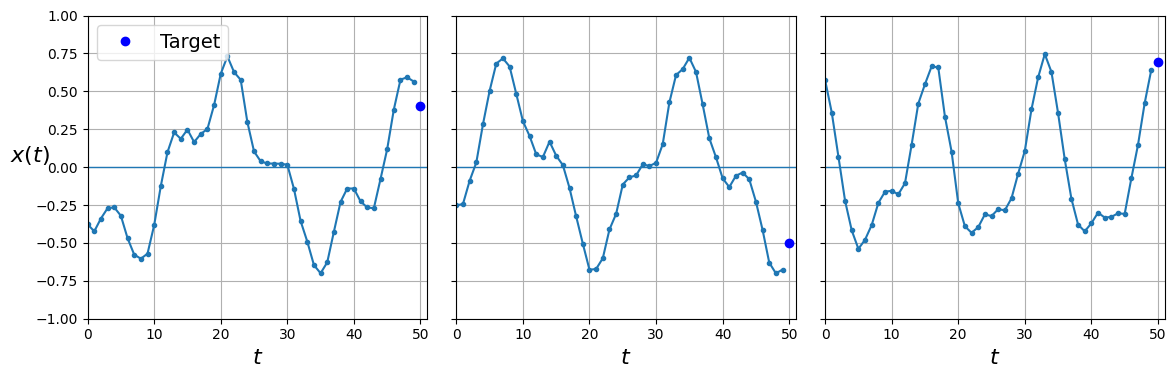

In [9]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

# Very brief Introduction to Recurrent Neural Networks (RNNs)
<img src="images/dse/rnn.png"
     width="70%"
     alt="Recurrent Neural Network Architecture"
     style="float: left; margin-right: 10px;" />

# RNN for time series (univariate) forecasting one step ahead

## Baseline Comparisons: naive and linear models

### Forecasting One Step Ahead: Naive Approach 

Just predict the last observed value.

In [10]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2022-11-26 06:51:05.015255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.020211367

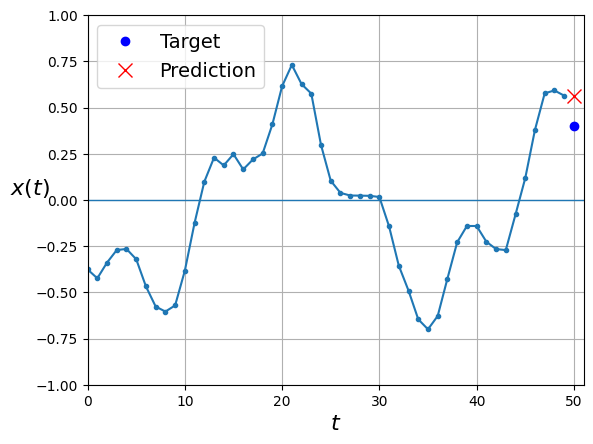

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Forecasting One Step Ahead: Linear Approach 

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0956 - val_loss: 0.0405
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0211
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0176 - val_loss: 0.0152
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0065

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004244192969053984

Look at the learning curves for the training and validation sets (reminder, can help check for overfitting).

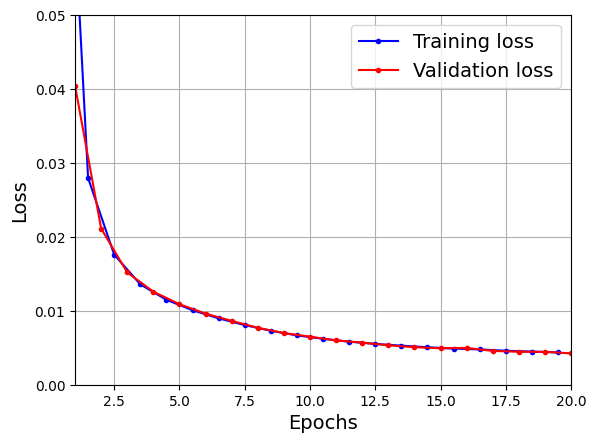

In [15]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    #plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 2ms/step


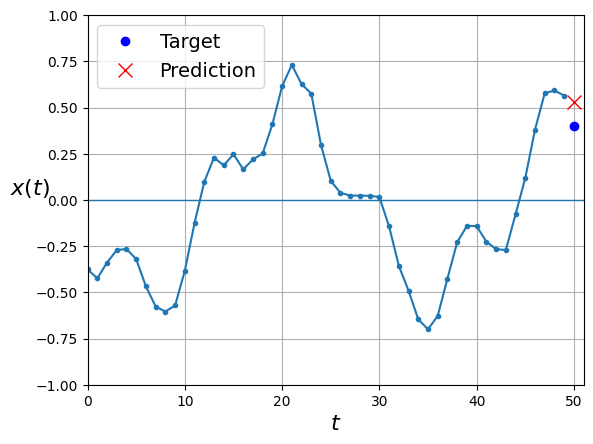

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

* Using a Simple RNN.  Just uses the current x<sub>t</sub> and a<sub>t-1</sub> to predict x<sub>t+1</sub>.  Thus there are only three parameters to learn (the weights for the two inputs (w<sub>x</sub>, w<sub>a-1</sub>) and the one output weight (w<sub>y</sub>) ). 

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.1241 - val_loss: 0.0339
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286 - val_loss: 0.0244
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0218 - val_loss: 0.0192
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0178 - val_loss: 0.0161
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0115 - val_loss: 0.0110

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [19]:
# https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/
Wax = model.get_weights()[0]
Waa = model.get_weights()[1]
ba = model.get_weights()[2]

print(f"Wax {Wax.shape} = {Wax}")
print(f"Waa {Waa.shape} = {Waa}")
print(f"ba {ba.shape} = {ba}")

Wax (1, 1) = [[1.6600738]]
Waa (1, 1) = [[-0.67378616]]
ba (1,) = [-0.00024169]


In [20]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010884899646043777

63/63 [==============================] - 0s 3ms/step


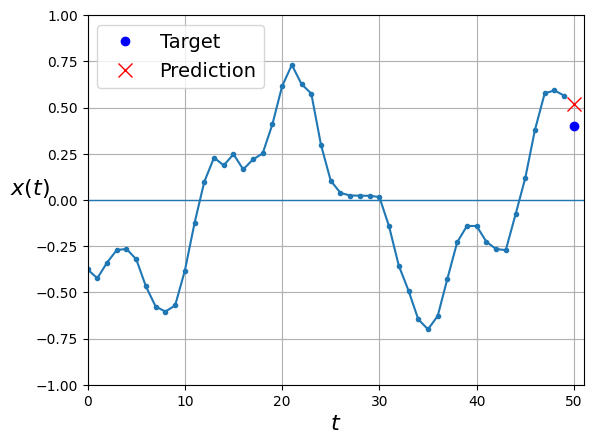

[[ 0.5169553 ]
 [-0.6038    ]
 [ 0.615127  ]
 ...
 [-0.1811584 ]
 [-0.18650022]
 [ 0.5050638 ]]


In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()
print(y_pred)

# Deep RNNs

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=False), # return_sequences=True if output to another RNN layer
    keras.layers.Dense(1, activation="linear")
    # keras.layers.SimpleRNN(1) # Usually better to use a Dense layer
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.0167 - val_loss: 0.0043
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0031 - val_lo

In [23]:
#weights = model.get_weights()
#for i in range(0, len(weights), 3 ):
#    print(f"a{i//3} = Wax {weights[i].shape} + Waa {weights[i+1].shape} + ba {weights[i+2].shape}")

weights = model.get_weights()
for i in range(len(weights)):
    print(f"{i} = W {weights[i].shape}")
model.summary()

0 = W (1, 20)
1 = W (20, 20)
2 = W (20,)
3 = W (20, 20)
4 = W (20, 20)
5 = W (20,)
6 = W (20, 1)
7 = W (1,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0026


0.0026042459066957235

63/63 [==============================] - 1s 7ms/step


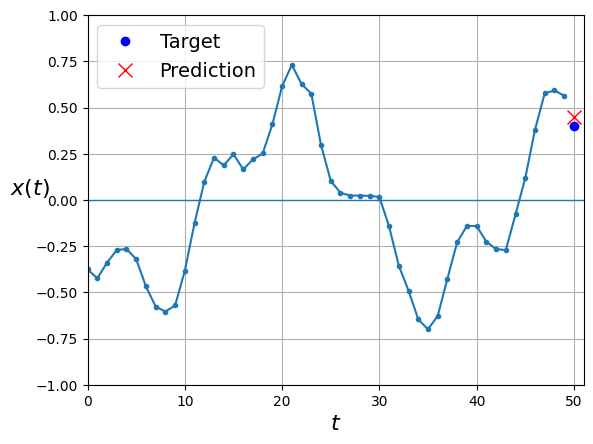

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# RNN for time series (univariate) forecasting multiple steps ahead

Want to predict mutiple time steps ahead

Two general approches

* Repeatedly use single time step prediction model, feed output back "pretend" it is real input.  Known as autoregressive prediction.

* Predict multiple time steps at once.

## RNN: Repeatedly predict single time step ahead

In [26]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 28ms/step


In [27]:
Y_pred.shape

(1, 10, 1)

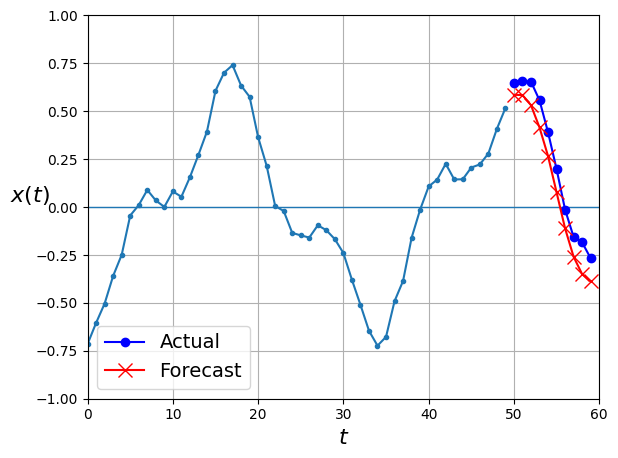

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 8ms/step


In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.024108363

## Baseline Comparisons: naive and linear models

### Forecasting Several Steps Ahead: Naive Approach 

In [31]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

### Forecasting Several Steps Ahead: Linear Approach 

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
# Because we use a validation model and MSE as the loss
# The evaluation metric is      val_loss = MSE ~ 0.0186
# This is much better than the naive model MSE ~ 0.2569

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1120 - val_loss: 0.0614
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0405
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0361 - val_loss: 0.0331
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0295
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0273
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0258
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0245
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0235
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0222

## RNN: Predict multiple time steps at once

Now let's create an RNN that predicts all 10 next values at once:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
# val_loss: 0.0084

Epoch 1/20
219/219 [==============================] - 14s 50ms/step - loss: 0.0620 - val_loss: 0.0349
Epoch 2/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0283 - val_loss: 0.0233
Epoch 3/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0216 - val_loss: 0.0194
Epoch 4/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 5/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 6/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 7/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 8/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 9/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 10/20
219/219 [==============================] - 10s 47ms/step - loss: 0.011

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_multi_rnn_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 1s 882ms/step


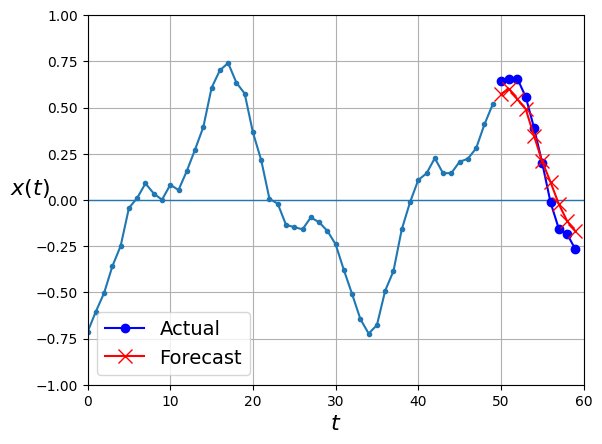

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_multi_rnn_pred)
plt.show()